In [10]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax.scipy.interpolate import RegularGridInterpolator

import jaxgym.components as comp
from jaxgym.stemoverfocus import compute_fourdstem_dataset_vmap, compute_fourdstem_dataset

from scipy.ndimage import rotate
from scipy.ndimage import zoom
import json

%matplotlib widget
jax.config.update('jax_platform_name', 'cpu')

In [11]:

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = np.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

# Set up grid coordinates corresponding to the physical centers of the pixels.
# Note: We use the rotated image’s physical edge lengths (sample_rotated_edge_length_x/y)
# to generate coordinates that match each pixel center.
sample_coords_x = np.linspace(-sample_rotated_edge_length_x/2,
                              +sample_rotated_edge_length_x/2,
                              sample_rotated.shape[1])

sample_coords_y = np.linspace(-sample_rotated_edge_length_y/2,
                              +sample_rotated_edge_length_y/2,
                              sample_rotated.shape[0])

# Flip the y-axis of the sample_rotated image because regular grid interpolator from jax cannot 
# handle a positive to negative grid coordinate
sample_rotated_flipped = np.flipud(sample_rotated)

# Build the RegularGridInterpolator
sample_interpolant = RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated_flipped,
    method='nearest', bounds_error=False, fill_value=0.0
)

extent = (
    sample_coords_x[0], sample_coords_x[-1],
    sample_coords_y[0], sample_coords_y[-1]
)

In [12]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 

## Descan Error matrix looks like this
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix

## NO Descan ERROR matrix looks like this - Remember that Axx, and Ayy in reality should be 1 for no error, 
# but if we set them to 1 to mean no error its a bit confusing, so we have offset their value inside the descanner. 
Axx, Ayy, Cxx, Cyy = 0, 0, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
semi_conv = 0.04
defocus = 0.01
camera_length = 1.0
scan_shape = sample_image_shape
det_shape = (96, 96)
scan_step = (0.0001, 0.0001) # XY Scan Step Pixel Size
det_px_size= (0.002, 0.002)
scan_rotation = 0

params_dict = {
    'semi_conv': semi_conv,
    'defocus': defocus, # Distance from the crossover to the sample
    'camera_length': camera_length, # Distance from the sample to the detector
    'scan_shape': scan_shape, #YX!
    'det_shape': det_shape, # YX!
    'scan_step': scan_step, # YX!
    'det_px_size': det_px_size, #YX!
    'scan_rotation': scan_rotation,
    'descan_error': descan_error,
    'flip_y': False,
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_step'], scan_shape=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), det_shape=params_dict['det_shape'], det_pixel_size=params_dict['det_px_size'], flip_y=params_dict['flip_y'])
model = [PointSource, ScanGrid, Descanner, Detector]

print(descan_error)

[0, 0, 0, 0, 0, 0, 0, 0]


Scan grid over Sample plot.

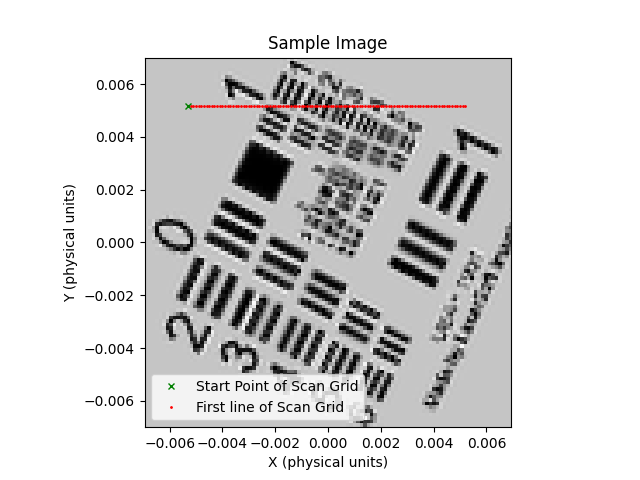

In [13]:
scan_coordinates = ScanGrid.coords
scan_coords = ScanGrid.coords.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)
interp_image = sample_interpolant((scan_coords[:, :, 1], scan_coords[:, :, 0]))

plt.figure()
plt.imshow(np.abs(interp_image), cmap='gray', extent=extent, origin='upper')
plt.plot(scan_coords[0, :, 0], scan_coords[0, :, 1], 'ro', markersize=1)
plt.plot(scan_coordinates[0, 0], scan_coordinates[0, 1], 'gx', markersize=5, label='Start Point of Scan Grid')
plt.plot([], [], 'ro', markersize=1, label='First line of Scan Grid')
plt.title('Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.legend()
plt.show()

Generating the forward dataset:

In [14]:
fourdstem_array = jnp.zeros((ScanGrid.scan_shape[0]*ScanGrid.scan_shape[1], *Detector.det_shape), dtype=jnp.complex64)

In [15]:
fourdstem_array = compute_fourdstem_dataset_vmap(
    model, fourdstem_array, sample_interpolant
)

In [16]:
fourdstem_array = fourdstem_array.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], *Detector.det_shape)

Plotting a scan coordinate

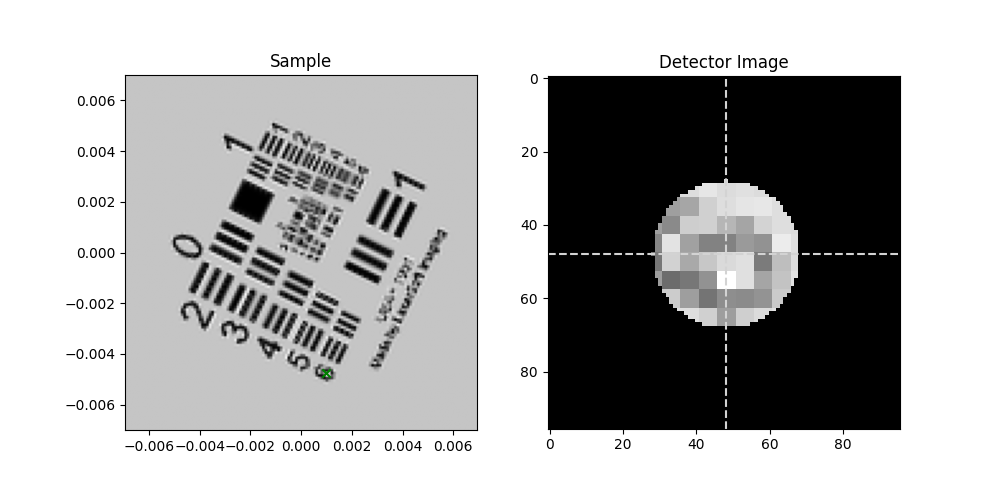

In [17]:
scan_idx_x, scan_idx_y = 63, 99
scan_pos_x, scan_pos_y = scan_coords[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray', origin='upper')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.det_shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.det_shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

Saving the data.

In [18]:
fourdstem_array = np.reshape(fourdstem_array, (ScanGrid.scan_shape[0]*ScanGrid.scan_shape[1], *Detector.det_shape))
json.dump(params_dict, open('params.json', 'w'), indent=2)
np.save('fourdstem_array.npy', fourdstem_array)